<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/02_classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: basic text classification**

| | |
|------|------|
| Filename | 02_classification_test.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 4, 2024 |
| Aim(s) | Build, train and evaluate a neural network machine learning model that classifies movie reviews as positives or negatives. |
| Dataset(s) | Stanford dataset [[1]](https://ai.stanford.edu/~amaas/data/sentiment/)|
| Version | Python 3.12 - TensorFlow 2.17.0 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution recommended if `training_phase="Yes"`.
3. Run all and read comments.

---

#### **Motivation**

AI is capable of managing and processing text made up of several thousand words, special characters and punctuation. In this Python code, the construction of the neural network and its optimization is similar to what has been done before. The main interest lies in the way the text is processed and broken down into elements.

For this, the Stanford Sentiment Treebank (SST) database, composed of over 50,000 movie reviews on the Internet, is used to build a binary classification neural network. A film review with a rating below 4/10 will be classified as negative and with a rating above 7/10 as positive.



---



#### **0. Input section**

The model has already been trained: **parameters** (weights and biases) of each neuron are already known according to the base dataset. The user can choose to keep these parameters and **not retrain the model** (No), or he can decide to repeat the **training phase** (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [77]:
training_phase = 'No'

---


#### **1. Import libraries & prebuilt dataset**

###### **1.1. Presentation of Python libraries**

`os`: provides functions to interact with the operating system (manipulating files and directories, accessing system information...)

`re`: performs complex searches and manipulations on strings (extracting substrings...)

`shutil`: provides utilities for performing operations on files and directories (copying, modifying, deleting...)

`string`: provides tools for handling and processing strings

`numpy`: library for scientific computing

`tensorflow`: builds and trains machine learning and deep learning models

`matplotlib.pyplot`: creates graphs

In [78]:
from os import path, listdir                                                # miscellaneous operating system interfaces
from re import escape                                                       # regular expressions
from shutil import rmtree                                                   # operations on files
from string import punctuation                                              # string manipulation
from numpy import shape, linalg, cos, sin, pi                               # scientific computing
from tensorflow import constant, keras, strings, expand_dims, data, metrics # machine learning models
from matplotlib.pyplot import subplots, title                               # graphing package

###### **1.2. Which database is used?**

The considered database is a version of the Stanford Sentiment Treebank (SST), a dataset created for sentiment analysis in movie reviews. It contains movie reviews labeled with sentiment (positive or negative) and is widely used to train and test sentiment analysis models. Movie reviews are contained into the compressed file `aclimdb`.


In [79]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1", url, extract=True, cache_dir='.', cache_subdir='')
dataset_dir = path.join(path.dirname(dataset), 'aclImdb')

###### **1.3. How data is organized within Stanford movie review database?**

Once the file is extracted, the following structure is composed of 5 folders: `train`, `test`, `README`, `imdbEr.txt` and `imdb.vocab`. The following code line is used to check file name into the directory.

*   `train`: contains movie reviews meant for training
*   `test`: contains movie reviews meant for testing
*   `README`: provides information about the dataset and how to use it
*   `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations

Within both the `test` and `train` folders, there are two subfolders:

*   `pos`: contains movie reviews with a positive sentiment (rating > 7/10)
*   `unsup`: contains unlabeled movie reviews for unsupervised learning
*   `neg`: contains movie reviews with a negative sentiment (rating < 4/10)

Each text file in these subfolders represents a single movie review and contains the raw text of the review. They are cleaned to contain only raw text, without additional metadata.

In [80]:
listdir(dataset_dir) # check the file names in the aclImdb directory

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [81]:
train_dir = path.join(dataset_dir, 'train') # path name of the "train" file in dataset_dir
remove_dir = path.join(train_dir, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
rmtree(remove_dir)

###### **1.4. How data is submitted during the learning phase**

A good practice for a machine learning experiment is to divide the dataset into 3 splits: `train`, `test` and `validation`. Two of them are already available. The validation set is created by using 20% of the training data set.

The 3 subsets are organized in batches for multiple reasons: memory, parallel computation, fast calculation of gradients, standardize the processing of training, validation and test sets... For this, the TensorFlow function `text_dataset_from_directory` is used to randomly shuffle texts present in the train folder and then divide this shuffle to generate the training dataset (80%) and the validation dataset (20%). Finally, for each dataset, all the data is grouped into batches of 32 texts.

The 3 subsets are stored in the data structures `tf.data.Dataset`. The data is not loaded into immediate memory, but generated when it is called up. The `show_text()` function displays an example of the text in the first batch of the data structure `tf.data.Dataset`.

In [82]:
def show_text(text_batch): # get the first text of the first batch
  for text_batch, label_batch in text_batch: # navigate through the text batch
      if label_batch.numpy()[0] == 0:
        print("Here's an extract from a negative review:")
        print(text_batch.numpy()[0])
      else:
        print("Here's an extract from a positive review:")
        print(text_batch.numpy()[0])

In [83]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', shuffle=True, seed=42) # 625 batches of 32 texts for training set randomly chosen
raw_val_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', shuffle=True, seed=42) # 157 batches of 32 texts for validation set randomly chosen
raw_test_ds = keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size) # 782 batches of 32 texts for test set

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [84]:
first_batch_train = raw_train_ds.take(1) # get the first batch of the training text set
show_text(first_batch_train) # show an example of movie review

Here's an extract from a negative review:
b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'


---


#### **2. Pre-processing & reformating data**

###### **2.1. How to switch from a verbal language to a machine language?**

The textual data is pre-processed and converted before being used by the model. Three crucial phases are established:
- standardization
- tokenization
- vectorization

The first pre-processing step standardizes text data by replacing upper case with lower case letters, by removing html tags and punctuation characters. The variable `punctuation` contains all punctuation characters to be removed. Special characters such as those with accents are not present in English texts. A standardization function is declared and used to process training data in the same way as other data (avoid training/testing bias).

In [85]:
ponctuation = escape(punctuation)
print("The punctuation characters eliminated are: \n", " \n", ponctuation)

The punctuation characters eliminated are: 
  
 !"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~


In [86]:
def standardization(input_data): # standardization function
  no_uppercases = strings.lower(input_data) # convert upper cases into lower cases...
  no_html = strings.regex_replace(no_uppercases, '<br />', ' ') # ... then remove HTML strings and...
  no_punctuation = strings.regex_replace(no_html, '[%s]' % ponctuation, '') # ... punctuation
  return no_punctuation

The second pre-processing step is to transform strings of all texts into integers (=neural network inputs). Text elements are separated, recombined into **tokens** and finally converted into integers (vectorization step). The tokenization process is performed by the Keras layer `TextVectorization` which transforms a batch of strings into either a list of token indices. The 5,000 most frequently used tokens are kept and stored in a dictionary [[2]](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). This threshold is used to eliminate words that aren't often used or that don't evoke feelings, such as actor names.

The dictionnary called **vocabulary** is built by using raw texts inputs of the training set (labels `y` are ignored).

In [87]:
max_features = 5000 # maximum number of words (=tokens) to consider in the vocabulary.
max_length = 500 # maximum number of words per review
vectorize_layer = keras.layers.TextVectorization(standardize=standardization, max_tokens=max_features, output_sequence_length=max_length, output_mode='int') # transform strings into sequences of integers

vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x)) # vectorization layer to learn the vocabulary from the raw texts in the training dataset

###### **2.2. How do you visualize these transformations?**

The first function `token_to_int` shows the transformation of text elements into integers. The second `int_to_token`is used to identify which token is associated with a given integer.

In [88]:
def token_to_int(raw_text):
  raw_text = next(iter(raw_text))[0]
  print("Review before tokenization and vectorization: \n", raw_text[0])
  print(" ")
  text_vectorized = expand_dims(raw_text, -1) #
  text_vectorized = vectorize_layer(text_vectorized)
  print("Review after tokenization and vectorization: \n", text_vectorized[0])

token_to_int(raw_train_ds)

Review before tokenization and vectorization: 
 tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer S

In [89]:
def int_to_token(index):
  token = vectorize_layer.get_vocabulary()[index]
  print("The integer %d represent the token: %s" %(index, token))

int_to_token(7)

The integer 7 represent the token: is


---


#### **3. Model and training**


###### **3.1. How to configure the datasets for performance?**

During the model training phase, the duration represents the time required to open the data file, read it and train with it. By default, these steps are performed one at a time. With a prefetch method, the model opens the data file, then executes a training step `s` and loads the data for step `s+1` at the same time. Loading the batch in the background during the training phase enables more efficient use of available computing resources, avoiding the risk of a "bottleneck" where computation (GPU) is limited by the speed at which data is supplied (I/O).

The overlapping of these steps is ensured by the `prefetch()` function, where the size of the prefetch buffer is automatically set by TensorFlow via the parameter `AUTOTUNE`.

The function `cache()` temporarily stores transformed data of a batch (standardization + tokenization + vectorization) in the RAM memory (12.7 GB RAM for a Google configuration). This method saves a significant amount of time since complex transformations applied to the texts are only performed during the first epoch and re-used for the others.

In [90]:
AUTOTUNE = data.AUTOTUNE # prefetch buffer size parameter

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE) # store raw_train_ds temporarily in the RAM + load the next batch in background with a prefetch buffer size computed by AUTOTUNE
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###### **3.2. What is a neural network formed of?**

**Pre-processing layer** `vectorize_layer`:
* **Inputs:** a text vector of dimension `batch_size` (=32).
* **Outputs:** an integer 2D tensor of dimensions (`batch_size`, `max_length`) (= (32, 500)).
* **Comments:** each text of the batch of 32 elements is truncated to the 501st (= `max_length`) and then an integer is associated with each of the 5,000 most frequently used words (= `max_features`) in the text dataset. The word index is referenced in a dictionary, called *vocabulary*, and is common to all texts in the dataset. If the text is less than 500 words long (= `max_length`), the output tensor is padded with zeros.

<br>**Embedding layer** `Embedding`: <br>
* **Inputs:** an integer 2D tensor of dimensions (`batch_size`, `max_length`) (= (32, 500)).
* **Outputs:** a float 3D tensor of dimensions (`batch_size`, `max_length`, `embedding_dim`) (=(32, 500, 16)).
* **Comments:** The Keras embedding layer manages its own dictionary, in which each word is linked to a dense vector of dimension `embedding_dim` (=16). The layer returns a 16-float vector for each element of the 2D tensor input. The Embedding dictionnary is modified/adapted during the learning phase since the 16-components of an embedding vecteor are considered as weights and modified by an optimization algorithm.

<br>**Pooling layer** `GlobalAveragePooling1D`: <br>
* **Inputs:** a float 3D tensor of dimensions (`batch_size`, `max_length`, `embedding_dim`) (=(32, 500, 16)).
* **Outputs:** a float 2D tensor of dimensions (`batch_size`, `embedding_dim`) (=(32, 16)).
* **Comments:** This layer will average all the 16-dense vectors of a text. This reduction loses the word order, but partially integrates the meaning of the text.

<br>**Fully-connected layer** `Dense`: <br>
* **Inputs:** a float 2D tensor of dimensions (`batch_size`, `embedding_dim`) (=(32, 16)).
* **Outputs:** maximum 32 scalars between 0 (=negative sentiment) and 1 (=positive sentiment).
* **Comments:** if this scalar is close to 0.5, the model cannot conclude with certainty.  


In [91]:
def create_model():
  embedding_dim = 16
  model = keras.Sequential()
  model.add(vectorize_layer) # pre-processing layer (standardization + tokenization + vectorization)
  model.add(keras.layers.Embedding(input_dim = max_features, output_dim = embedding_dim))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1, activation='sigmoid')) # 1 output: propbability

  model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[metrics.BinaryAccuracy()])

  return model

###### **3.3. How to train the model?**


In [92]:
if training_phase == "Yes":
  checkpoint_path = "02_classification_text.weights.h5"
  cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
  stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True, min_delta=0.001)

In [93]:
model = create_model()

In [94]:
if training_phase == "Yes":
  history = model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=100, callbacks=[stop_early, cp_callback], verbose=0)
  val_acc_per_epoch = history.history['val_binary_accuracy'] # best val_binary_accuracy achived at epoch 32
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch))
else:
  !git clone https://github.com/Benjamin-morel/TensorFlow.git # go to the Github repertory TensorFlow and clone it
  model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=1, verbose=0)
  model.load_weights("TensorFlow/02_classification_text.weights.h5") # import weights from the cloned repertory
  !rm -rf TensorFlow/ # delete the cloned repertory

Cloning into 'TensorFlow'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 111 (delta 47), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 18.01 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [95]:
def show_evolution(history):
  history_dict = history.history
  acc_train = history_dict['binary_accuracy']
  acc_val = history_dict['val_binary_accuracy']
  epochs = range(1, len(acc_train) + 1)

  fig, ax = subplots(figsize=(8, 6))
  ax.plot(epochs, acc_train, label='Training', color='blue')
  ax.plot(epochs, acc_val, label='Validation', color='orange')
  ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), frameon=True, facecolor='white', edgecolor='black', fontsize=10)
  ax.set_xlabel('Epochs', fontsize=12), ax.set_ylabel('Binary Accuracy', fontsize=12)
  ax.grid(True, linestyle='--', alpha=0.6)
  fig.show()

In [96]:
if training_phase == 'Yes':
  show_evolution(history)

---


#### **4. Evaluation and prediction**


In [97]:
loss, accuracy = model.evaluate(raw_test_ds)

print(f"""
  {round(100*accuracy, 3)}% of the test set is corretly predicted
  """)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8782 - loss: 0.3054

  88.024% of the test set is corretly predicted
  


It is now possible to use the trained model to recognize the sentiment of the author of a film review. Write your own review in the next section and check the model's prediction.

In [98]:
my_review = ["This movie was terrible and boring. Most of scenes were violents and useless."]

In [99]:
examples = constant(my_review)

prediction = model.predict(examples)
if prediction < 0.5:
  print("The movie looks pretty bad. (score model: ", round(prediction[0][0], 1), ")")
else:
  print("Great movie, go see it in the cinema! (score model: ", round(prediction[0][0], 1), ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
The movie looks pretty bad. (score model:  0.1 )


---


#### **5. Let's explore the embedding dictionnary**

For the embedding dictionnary exploration, the 16 values from the 5000 vectors are extracted. As a reminder, these vectors are the weights of the Embedding layer and can be retrieved using the function `get_weights`.

In [100]:
embeddings_vector = model.layers[1].get_weights()[0] # embedding layer is the second layer of the model
print("The dictionnary size is equal to:",(shape(embeddings_vector)))
dictionary_embedding = {vectorize_layer.get_vocabulary()[i]:embeddings_vector[i] for i in range(max_features)}

The dictionnary size is equal to: (5000, 16)


Then, it's essential to associate a word with its vector given by the embedding dictionary. To do this, another dictionary `word_to_embeddings_vector` is built, containing the 16 real values of the dense vector's components for the 5000 most frequently used words. An example is given by entering the word "good" in the dictionary.

In [101]:
dictionary_embedding["good"]

array([-0.74045223,  0.72797775, -0.81483996,  0.7455467 , -0.5748099 ,
       -0.72785854, -0.6728519 ,  0.708197  ,  0.65778595,  0.6499005 ,
       -0.7387788 ,  0.7020209 , -0.7547246 , -0.67552066, -0.7161834 ,
       -0.79400253], dtype=float32)

In [102]:
def get_distance(token1, token2):
  p1 = dictionary_embedding[token1] # position of token 1 in the 16 dimensions embedding space
  p2 = dictionary_embedding[token2] # position of token 2
  distance = np.linalg.norm(p2-p1) # norm computation
  return distance

def get_synomym(token, n):
  p1 = dictionary_embedding[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, 1000):
    token_candidate = vectorize_layer.get_vocabulary()[i]
    candidate_list[token_candidate] = get_distance(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  synonym_list = sorted_items[1:n+1]
  words = [item[0] for item in synonym_list]
  distance = [item[1] for item in synonym_list]

  fig, ax = subplots(figsize=(6, 6))

  for i in range(len(distance)):
      x = distance[i] * cos((i + 1) * 2*pi / len(distance))
      y = distance[i] * sin((i + 1) * 2*pi / len(distance))

      ax.scatter(0, 0, color='red', s=50)
      ax.text(0, 0.1, word, fontsize=12, color='red', ha='center', va='center')
      ax.scatter(x, y, color='black', s=15)
      ax.text(x, y+0.1, words[i], fontsize=10, color='black', ha='center', va='center')

  ax.set_xlim(-1.1*max(distance), 1.1*max(distance))
  ax.set_ylim(-1.1*max(distance), 1.1*max(distance))
  ax.set_aspect('equal'), ax.axis('off')
  title("Neighbors of %s" %word, fontsize=16)
  fig.show()

In [103]:
get_distance("nice", "terrible")

20.256641

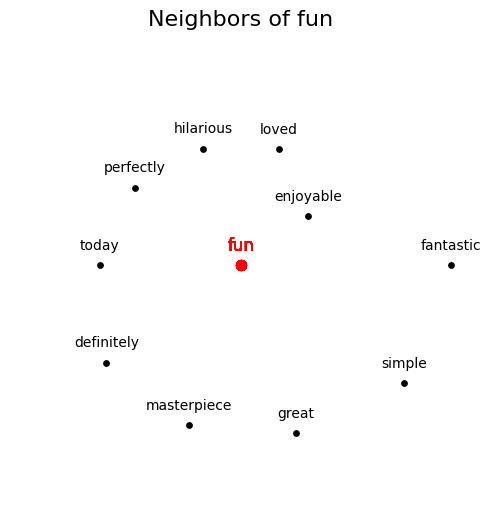

In [104]:
word = "fun" # which word to seek neighbors for?
nb = 10 # how many?
get_synomym(word, nb)